In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics, manifold
from tqdm import tqdm
import gensim.downloader as gensim_api
import transformers
import os

In [2]:
df=pd.read_csv('clean_spanish.csv')
print(df)

                                                 Text
0   and to think that they had earned our respect ...
1   and for what what do you want to prove i am a ...
2   i agree for what is which the most of men are ...
3   that no one understands that these women are b...
4   but let s see let s go on strike so that they ...
..                                                ...
61  the only thing they are going to achieve is ac...
62                                   hours of silence
63                                  fucking feminazis
64  a day without feminazis not a day without wome...
65                          we have to make it global

[66 rows x 1 columns]


In [3]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [4]:
nlp.most_similar(["nigger"], topn=3)

[('slur', 0.5023007392883301),
 ('niggers', 0.5003144145011902),
 ('faggot', 0.4708784222602844)]

In [5]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [6]:
def similarWords(words, top, nlp):
    out = words
    for tupl in nlp.most_similar(words, topn=top):
        out.append(tupl[0])
    return list(set(out))

In [7]:
clusters={}
clusters['Hate']=get_similar_words(['nigger'], top=30, nlp=nlp)

In [8]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('al', do_lower_case=True)
nlp = transformers.TFDistilBertModel.from_pretrained('al')

Some layers from the model checkpoint at al were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at al.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [9]:
def utils_bert_embedding(txt, tokenizer, nlp):
    '''
    Word embedding with Bert (equivalent to nlp["word"]).
    :parameter
        :param txt: string 
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
    :return
        tensor sentences x words x vector (1x3x768) 
    '''
    # tokenize sentence to tokens (integers)
    idx = tokenizer.encode(txt)
    # convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = np.array(idx)[None,:]
    # generate embeddings for each token - output is a tuple
    embedding = nlp(idx)
    # select first member of the tuple, remove first dimension which is 1 to get (num_words,embedding size 712)
    # exclude CLS and EOS tokens
    X = np.array(embedding[0][0][1:-1])
    return X

In [10]:
%%time
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(df['Text'])]

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:15<00:00,  4.24it/s]

Wall time: 15.6 s


In [11]:
X = np.array(lst_mean_vecs)
X.shape

(66, 768)

In [12]:
np.savetxt("mean_vec1.csv", X, delimiter="/")

In [13]:
print(X)

[[-0.04548696  0.176633    0.17845267 ... -0.19024503  0.17161676
  -0.0337127 ]
 [-0.00708912  0.21018147  0.16418189 ... -0.19656913  0.2535444
  -0.04383207]
 [-0.09454912  0.24121548  0.07401357 ... -0.27371418  0.26381043
   0.01797428]
 ...
 [ 0.31398273 -0.04943658  0.10800932 ... -0.31103295  0.09455757
   0.05683009]
 [-0.09919377 -0.0013964   0.17493321 ... -0.23738423  0.19299567
   0.23965828]
 [ 0.05497495 -0.03442862 -0.08954098 ... -0.34679437  0.4187558
   0.06945366]]


In [14]:
from numpy import genfromtxt
my_data = genfromtxt('mean_vec1.csv', delimiter='/')
print(my_data)

[[-0.04548696  0.176633    0.17845267 ... -0.19024503  0.17161676
  -0.0337127 ]
 [-0.00708912  0.21018147  0.16418189 ... -0.19656913  0.25354439
  -0.04383207]
 [-0.09454912  0.24121548  0.07401357 ... -0.27371418  0.26381043
   0.01797428]
 ...
 [ 0.31398273 -0.04943658  0.10800932 ... -0.31103295  0.09455757
   0.05683009]
 [-0.09919377 -0.0013964   0.17493321 ... -0.23738423  0.19299567
   0.23965828]
 [ 0.05497495 -0.03442862 -0.08954098 ... -0.34679437  0.4187558
   0.06945366]]


In [15]:
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(clusters.items())}

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


In [16]:
print(dic_y.keys())

dict_keys(['Hate'])


In [17]:
def fix_NAN_inf_values(x):
    '''Replace NaN with zero and infinity with large finite numbers'''
    if len(np.where(np.isnan(X))[0])>0 or len(np.where(np.isnan(X))[1])>0:
        return np.nan_to_num(X)

In [18]:
similarities = np.array(
            [metrics.pairwise.cosine_similarity(X, [dic_y['Hate']]).T.tolist()[0]]
            ).T

In [19]:
print(similarities)

[[0.53339499]
 [0.52718532]
 [0.53678954]
 [0.51005393]
 [0.53176636]
 [0.54419667]
 [0.49905148]
 [0.53336132]
 [0.51038408]
 [0.53341883]
 [0.53390372]
 [0.5341242 ]
 [0.51280594]
 [0.53427982]
 [0.53708565]
 [0.49324328]
 [0.52326447]
 [0.51032937]
 [0.52730095]
 [0.52564007]
 [0.51730049]
 [0.55091947]
 [0.50446647]
 [0.53615481]
 [0.50895035]
 [0.51302344]
 [0.55479234]
 [0.49984112]
 [0.52950817]
 [0.50395161]
 [0.49567717]
 [0.52880573]
 [0.4888908 ]
 [0.49264994]
 [0.52738982]
 [0.51769662]
 [0.52417409]
 [0.51703   ]
 [0.56271553]
 [0.50188822]
 [0.48091015]
 [0.5025444 ]
 [0.53896093]
 [0.51814806]
 [0.48053277]
 [0.55474222]
 [0.51645887]
 [0.54287648]
 [0.55823296]
 [0.46962753]
 [0.50386888]
 [0.49778175]
 [0.52046698]
 [0.54044783]
 [0.5272429 ]
 [0.50069278]
 [0.48238105]
 [0.45900133]
 [0.49440578]
 [0.4285222 ]
 [0.42026839]
 [0.484956  ]
 [0.35025015]
 [0.51389551]
 [0.53095341]
 [0.42032224]]


In [20]:
import matplotlib.pyplot as plt

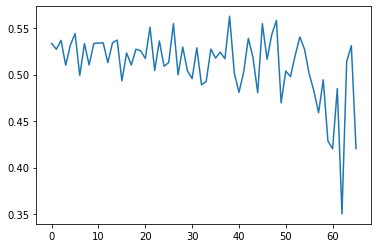

In [21]:
plt.plot(similarities)

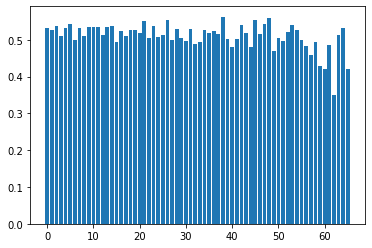

In [22]:
y=[]
for similarity in similarities:
    y.append(similarity[0])

x=np.arange(df.shape[0])
plt.bar(x,height=y)
plt.show()

In [31]:
retrieved=(similarities>0.5).sum()
print(retrieved)


48


In [24]:
# tp=0
# for i in range (0,4000):
#     if(similarities[i]>0.50 and z[i]<2):
#         tp=tp+1
# print(tp)

In [25]:
# precision=tp/retrieved
# print("Precision is",precision)

In [26]:
# fn=0
# for i in range (0,4000):
#     if(similarities[i]<0.50 and z[i]<2):
#         fn=fn+1
# recall=tp/(fn+tp)
# print("Recall is",recall)

In [27]:
# fp=retrieved-tp
# tn=0
# for i in range (0,4000):
#     if(similarities[i]<0.50 and z[i]==2):
#         tn=tn+1
# accuracy=(tp+tn)/(tp+tn+fn+fp)
# print("Accuracy is",accuracy)